## Create Initial states

In [1]:
import numpy as np
from pathlib import Path
import os
import pandas as pd
import torch

from skorch import NeuralNetRegressor
from skorch.callbacks import EarlyStopping
from skorch.callbacks import Checkpoint

from src.models.normal_deg import NormalDegradationModel as NModel, NormalDegradationNLL as NLoss
from src.pipelines.init_states import PlotNormalDistWithData,ThresholdCheckpoint

In [2]:
data_name = "DS03"

device = "cuda" if torch.cuda.is_available() else "cpu"
experiment_dir = Path('experiments')/data_name
states_dir = experiment_dir/'states'
os.makedirs(states_dir, exist_ok=True)

## Import training data


In [3]:
hi_df = pd.read_csv(experiment_dir/'hidata_dev.csv')

### get only degraded data

In [4]:
hi_df = hi_df[hi_df['hs']==0]
del hi_df['hs']

In [5]:
perform_alias = [col for col in hi_df.columns if col not in ['unit','cycle']]
units = hi_df['unit'].unique().tolist()

In [6]:
performs_train = {alias: 
    {int(unit): hi_df[hi_df['unit']==unit][alias].values for unit in units} 
    for alias in perform_alias
}
time_train = {int(unit): hi_df[hi_df['unit']==unit]['cycle'].values for unit in units}

In [7]:
s_np:np.ndarray = performs_train['T48'][1]
t_np:np.ndarray = time_train[1]
onset = float(t_np[0])
X = s_np.reshape(-1, 1)                 # dummy input
y = t_np.reshape(-1, 1)  

## Model initialization

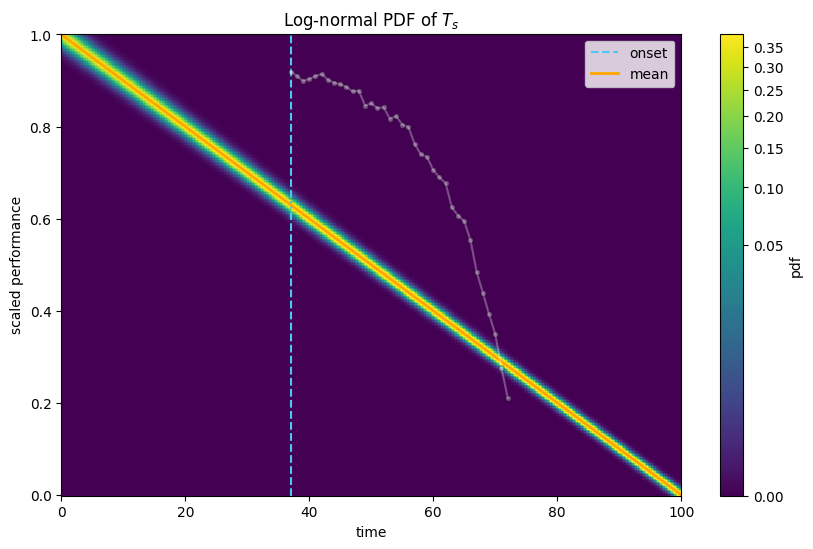

In [8]:
# grids
t = np.linspace(0.1, 100, 400)  # Start from 0.1 instead of 0.0 (LogNormal support is t > 0)
s = np.linspace(0.0, 1.0, 300)

model = NModel(onset=onset)

ax = model.plot_distribution(
    t=t,
    s=s,
    func="pdf",
    title="Log-normal PDF of $T_s$",
)

ax.plot(t_np,s_np,'o-',
		color='white',alpha=0.3,markersize=4,markeredgecolor='black',markeredgewidth=0.8,
  		label='data')
display()

## Create Initial Particles (Training)
The number of (pure) particles $N$ is the the number of training trajectories.

### Callbacks

In [9]:
plot_cb = PlotNormalDistWithData(
    t_grid=t,
    s_grid=s,
    time_data=t_np,          # or list of arrays
    perform_data=s_np,       # same structure
    plot_every=2000,
    func="pdf",
)

early_stop_cb = EarlyStopping(
    monitor="train_loss",
    patience=500,
    threshold=1e-5,
    threshold_mode="rel",
    lower_is_better=True,
)

checkpoint_cb =	Checkpoint(
    monitor="train_loss_best",
    dirname=states_dir,  
    f_params="best_model.pt",
    f_optimizer="best_optimizer.pt",
    f_history="history.json",
    f_criterion="criterion.pt",
)


delayed_ckpt_cb = ThresholdCheckpoint(checkpoint=checkpoint_cb,min_delta=0.01)

Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss     dur
-------  ------------  ------
      1      491.6582  0.2107
      2      481.2301  0.0027
      3      470.9599  0.0022
      4      460.8499  0.0022
      5      450.9017  0.0022
      6      441.1167  0.0025
      7      431.4963  0.0029
      8      422.0419  0.0029
      9      412.7541  0.0029
     10      403.6336  0.0029
     11      394.6815  0.0029
     12      385.8974  0.0029
     13      377.2821  0.0029
     14      368.8354  0.0029
     15      360.5568  0.0029
     16      352.4459  0.0028
     17      344.5022  0.0029
     18      336.7250  0.0029
     19      329.1134  0.0029
     20      321.6658  0.0029
     21      314.3814  0.0029
     22      307.2586  0.0028
     23      300.2956  0.0029
     24      293.4910  0.0028
     25      286.8428  0.0029
     26      280.3492  0.0029
     27      274.0082  0.0028
     28      267.8174  0.0028
     29      261.7745 

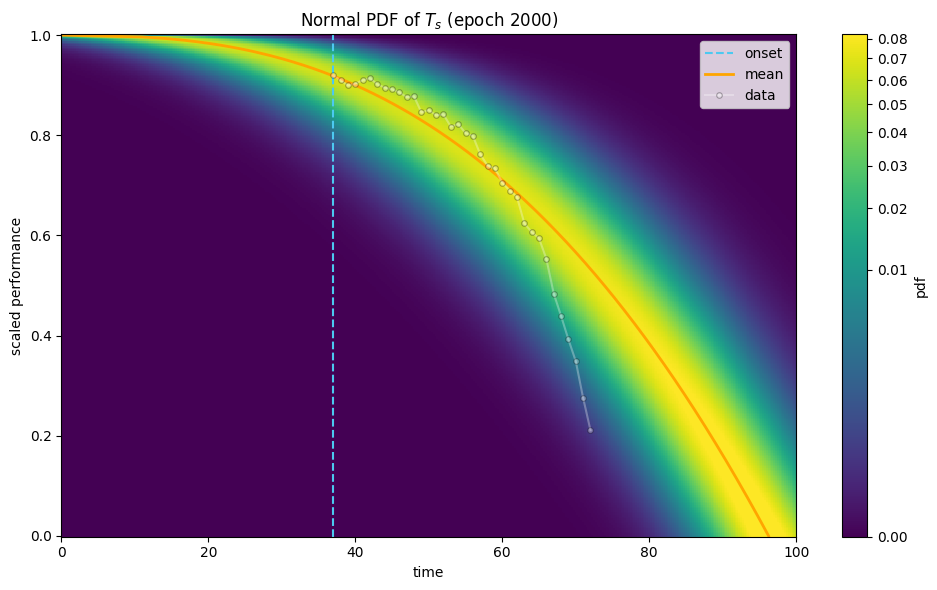

   2000        3.2669  0.0029
   2001        3.2668  0.0036
   2002        3.2667  0.0029
   2003        3.2666  0.0033
   2004        3.2665  0.0030
   2005        3.2664  0.0030
   2006        3.2663  0.0031
   2007        3.2662  0.0030
   2008        3.2661  0.0029
   2009        3.2660  0.0029
   2010        3.2659  0.0030
   2011        3.2658  0.0029
   2012        3.2657  0.0029
   2013        3.2656  0.0029
   2014        3.2655  0.0028
   2015        3.2654  0.0029
   2016        3.2653  0.0029
   2017        3.2652  0.0029
   2018        3.2651  0.0030
   2019        3.2650  0.0029
   2020        3.2649  0.0029
   2021        3.2648  0.0029
   2022        3.2647  0.0029
   2023        3.2646  0.0029
   2024        3.2645  0.0029
   2025        3.2644  0.0030
   2026        3.2643  0.0029
   2027        3.2642  0.0028
   2028        3.2641  0.0029
   2029        3.2640  0.0029
   2030        3.2639  0.0029
   2031        3.2638  0.0027
   2032        3.2637  0.0029
   2033   

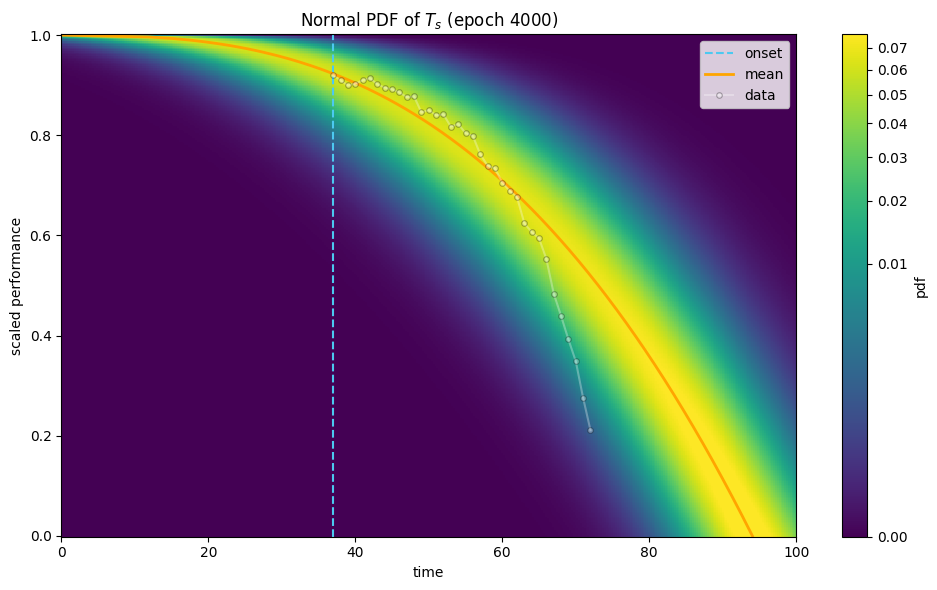

   4000        3.1338  0.0028
   4001        3.1337  0.0036
   4002        3.1337  0.0028
   4003        3.1336  0.0028
   4004        3.1335  0.0028
   4005        3.1334  0.0030
   4006        3.1333  0.0031
   4007        3.1332  0.0031
   4008        3.1332  0.0030
   4009        3.1331  0.0030
   4010        3.1330  0.0033
   4011        3.1329  0.0030
   4012        3.1328  0.0029
   4013        3.1327  0.0024
   4014        3.1327  0.0024
   4015        3.1326  0.0029
   4016        3.1325  0.0028
   4017        3.1324  0.0030
   4018        3.1323  0.0029
   4019        3.1322  0.0030
   4020        3.1322  0.0030
   4021        3.1321  0.0030
   4022        3.1320  0.0030
   4023        3.1319  0.0030
   4024        3.1318  0.0030
   4025        3.1317  0.0030
   4026        3.1316  0.0027
   4027        3.1316  0.0026
   4028        3.1315  0.0039
   4029        3.1314  0.0033
   4030        3.1313  0.0025
   4031        3.1312  0.0025
   4032        3.1311  0.0030
   4033   

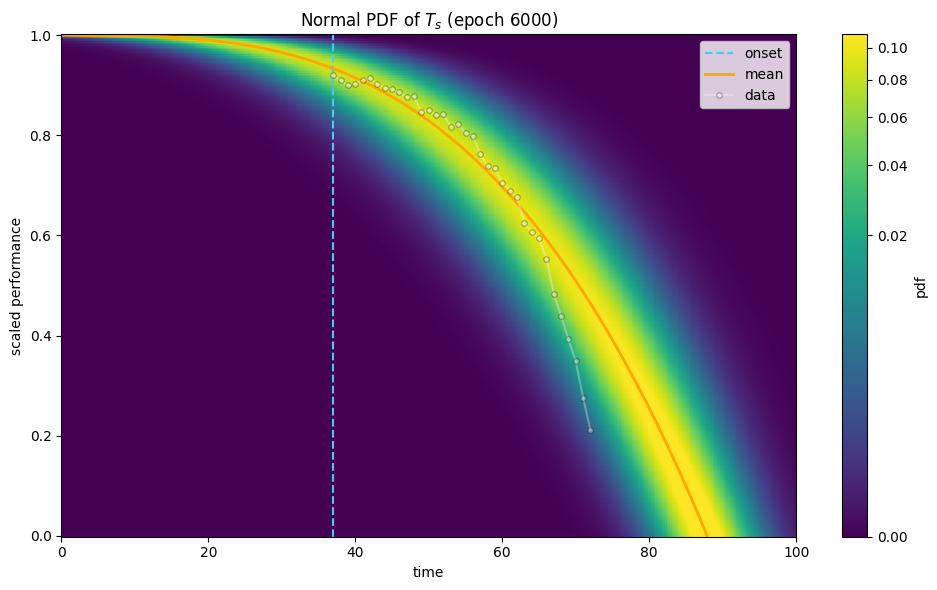

   6000        2.7670  0.0029
   6001        2.7666  0.0038
   6002        2.7662  0.0029
   6003        2.7659  0.0029
   6004        2.7655  0.0032
   6005        2.7651  0.0031
   6006        2.7648  0.0031
   6007        2.7644  0.0032
   6008        2.7640  0.0028
   6009        2.7637  0.0025
   6010        2.7633  0.0027
   6011        2.7629  0.0031
   6012        2.7626  0.0029
   6013        2.7622  0.0025
   6014        2.7618  0.0025
   6015        2.7615  0.0028
   6016        2.7611  0.0031
   6017        2.7607  0.0030
   6018        2.7604  0.0030
   6019        2.7600  0.0026
   6020        2.7596  0.0025
   6021        2.7593  0.0025
   6022        2.7589  0.0031
   6023        2.7585  0.0031
   6024        2.7581  0.0031
   6025        2.7578  0.0030
   6026        2.7574  0.0027
   6027        2.7570  0.0025
   6028        2.7566  0.0025
   6029        2.7563  0.0030
   6030        2.7559  0.0031
   6031        2.7555  0.0031
   6032        2.7552  0.0031
   6033   

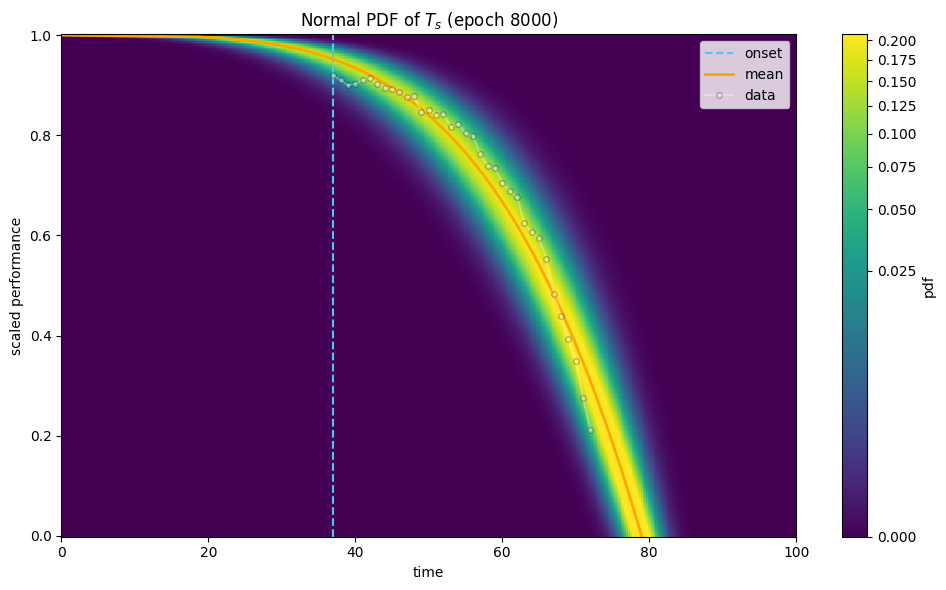

   8000        2.2026  0.0030
   8001        2.2026  0.0031
   8002        2.2026  0.0023
   8003        2.2026  0.0023
   8004        2.2026  0.0031
   8005        2.2026  0.0032
   8006        2.2026  0.0031
   8007        2.2026  0.0031
   8008        2.2025  0.0024
   8009        2.2025  0.0023
   8010        2.2025  0.0024
   8011        2.2025  0.0031
   8012        2.2025  0.0027
   8013        2.2025  0.0023
   8014        2.2025  0.0023
   8015        2.2025  0.0030
   8016        2.2025  0.0032
   8017        2.2025  0.0031
   8018        2.2025  0.0030
   8019        2.2025  0.0030
   8020        2.2024  0.0032
   8021        2.2024  0.0031
   8022        2.2024  0.0031
   8023        2.2024  0.0031
   8024        2.2024  0.0030
   8025        2.2024  0.0031
   8026        2.2024  0.0032
   8027        2.2024  0.0032
   8028        2.2024  0.0031
   8029        2.2024  0.0031
   8030        2.2023  0.0031
   8031        2.2023  0.0022
   8032        2.2023  0.0023
   8033   

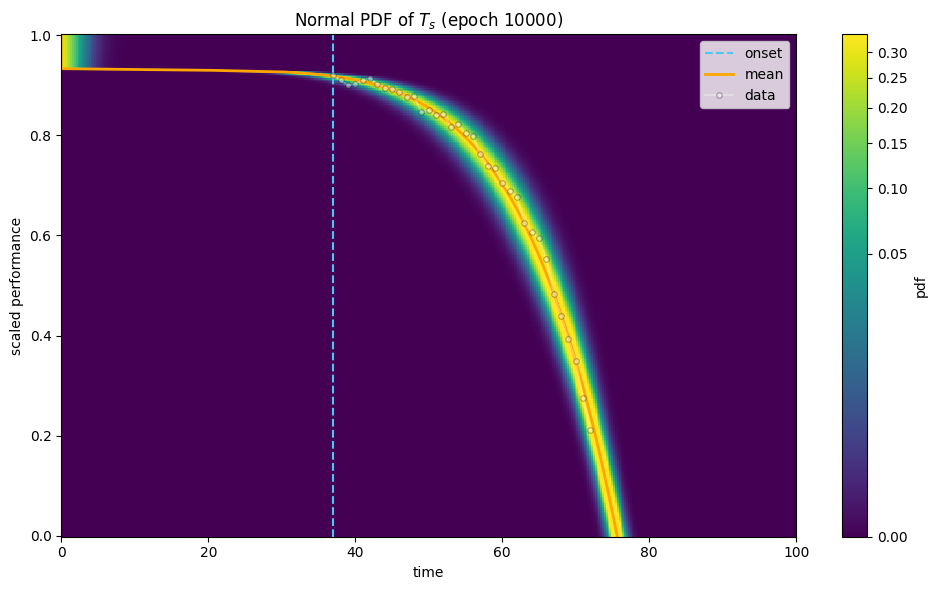

  10000        1.4556  0.0032
  10001        1.4556  0.0047
  10002        1.4556  0.0032
  10003        1.4556  0.0029
  10004        1.4556  0.0027
  10005        1.4556  0.0027
  10006        1.4556  0.0034
  10007        1.4556  0.0034
  10008        1.4556  0.0037
  10009        1.4556  0.0034
  10010        1.4556  0.0034
  10011        1.4556  0.0030
  10012        1.4556  0.0026
  10013        1.4556  0.0026
  10014        1.4556  0.0033
  10015        1.4556  0.0031
  10016        1.4556  0.0029
  10017        1.4556  0.0029
  10018        1.4556  0.0031
  10019        1.4556  0.0030
  10020        1.4556  0.0026
  10021        1.4556  0.0026
  10022        1.4556  0.0031
  10023        1.4556  0.0032
  10024        1.4556  0.0026
  10025        1.4556  0.0026
  10026        1.4556  0.0028
  10027        1.4556  0.0032
  10028        1.4556  0.0034
  10029        1.4556  0.0034
  10030        1.4556  0.0034
  10031        1.4556  0.0032
  10032        1.4556  0.0032
  10033   

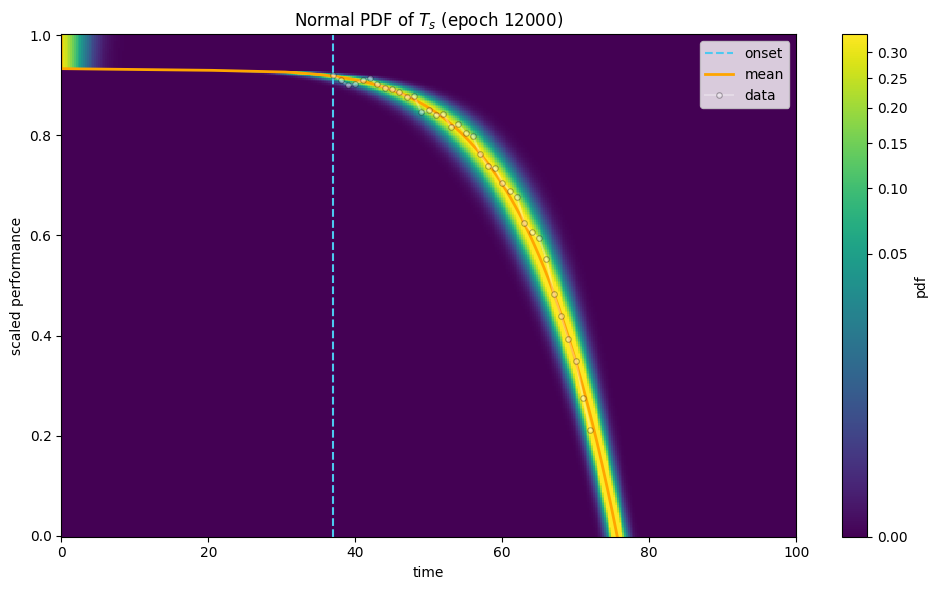

  12000        1.4546  0.0028
  12001        1.4546  0.0040
  12002        1.4546  0.0030
  12003        1.4546  0.0034
  12004        1.4546  0.0031
  12005        1.4546  0.0027
  12006        1.4546  0.0029
  12007        1.4546  0.0033
  12008        1.4545  0.0032
  12009        1.4545  0.0034
  12010        1.4545  0.0030
  12011        1.4545  0.0030
  12012        1.4545  0.0032
  12013        1.4545  0.0033
  12014        1.4545  0.0027
  12015        1.4545  0.0027
  12016        1.4545  0.0030
  12017        1.4545  0.0032
  12018        1.4545  0.0033
  12019        1.4545  0.0032
  12020        1.4545  0.0027
  12021        1.4545  0.0026
  12022        1.4545  0.0032
  12023        1.4545  0.0031
  12024        1.4545  0.0027
  12025        1.4545  0.0027
  12026        1.4545  0.0032
  12027        1.4545  0.0031
  12028        1.4545  0.0027
  12029        1.4545  0.0026
  12030        1.4545  0.0033
  12031        1.4545  0.0031
  12032        1.4545  0.0026
  12033   

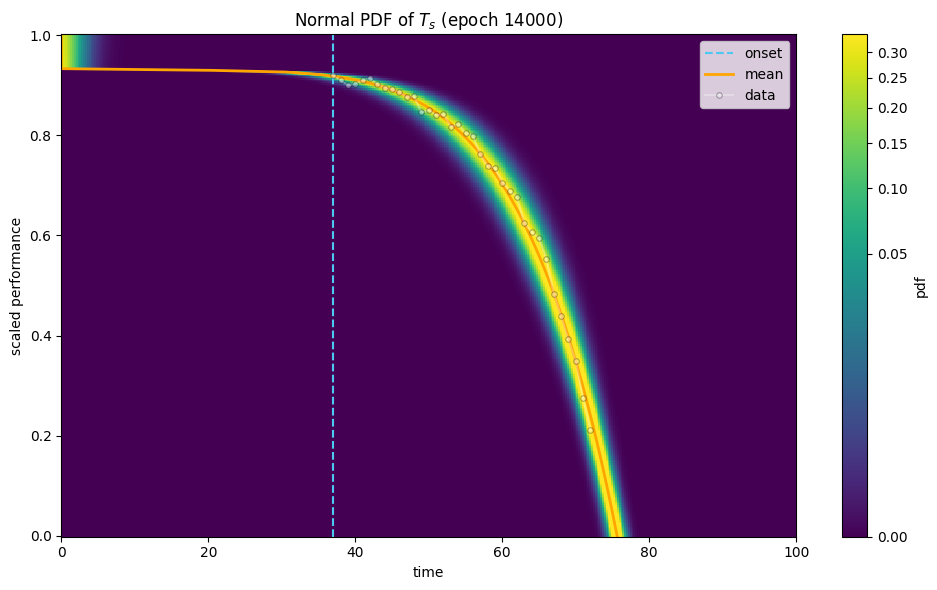

  14000        1.4543  0.0027
  14001        1.4543  0.0033
  14002        1.4543  0.0026
  14003        1.4543  0.0025
  14004        1.4543  0.0025
  14005        1.4543  0.0026
  14006        1.4543  0.0025
  14007        1.4543  0.0023
  14008        1.4543  0.0030
  14009        1.4543  0.0032
  14010        1.4543  0.0026
  14011        1.4543  0.0025
  14012        1.4543  0.0031
  14013        1.4543  0.0034
  14014        1.4543  0.0034
  14015        1.4543  0.0031
  14016        1.4543  0.0025
  14017        1.4543  0.0026
  14018        1.4543  0.0035
  14019        1.4543  0.0033
  14020        1.4543  0.0025
  14021        1.4543  0.0025
  14022        1.4543  0.0034
  14023        1.4543  0.0031
  14024        1.4543  0.0025
  14025        1.4543  0.0027
  14026        1.4543  0.0034
  14027        1.4543  0.0026
  14028        1.4543  0.0025
  14029        1.4543  0.0027
  14030        1.4543  0.0036
  14031        1.4543  0.0029
  14032        1.4543  0.0025
  14033   

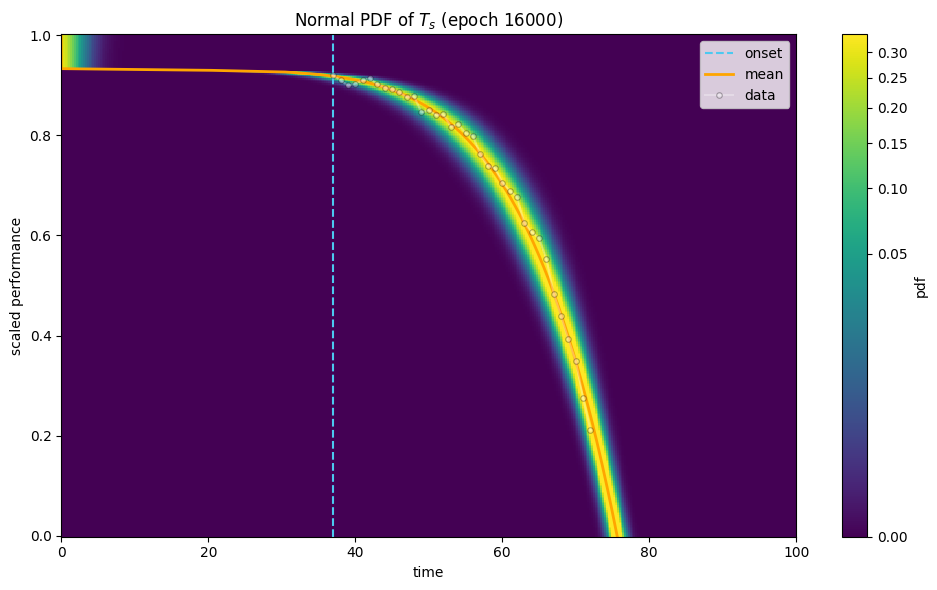

  16000        1.4542  0.0025
  16001        1.4542  0.0033
  16002        1.4542  0.0027
  16003        1.4542  0.0036
  16004        1.4542  0.0030
  16005        1.4542  0.0026
  16006        1.4542  0.0026
  16007        1.4542  0.0026
  16008        1.4542  0.0025
  16009        1.4542  0.0026
  16010        1.4542  0.0026
  16011        1.4542  0.0026
  16012        1.4542  0.0028
  16013        1.4542  0.0036
  16014        1.4542  0.0027
  16015        1.4542  0.0028
  16016        1.4542  0.0026
  16017        1.4542  0.0025
  16018        1.4542  0.0033
  16019        1.4542  0.0036
  16020        1.4542  0.0035
  16021        1.4542  0.0026
  16022        1.4542  0.0025
  16023        1.4542  0.0033
  16024        1.4542  0.0036
  16025        1.4542  0.0035
  16026        1.4542  0.0028
  16027        1.4542  0.0025
  16028        1.4542  0.0024
  16029        1.4542  0.0026
  16030        1.4542  0.0034
  16031        1.4542  0.0036
  16032        1.4542  0.0036
  16033   

,module,NormalDegradationModel()
,criterion,<class 'src.m...gradationNLL'>
,optimizer,<class 'torch...im.adam.Adam'>
,lr,0.01
,max_epochs,100000
,batch_size,-1
,iterator_train,<class 'torch...r.DataLoader'>
,iterator_valid,<class 'torch...r.DataLoader'>
,dataset,<class 'skorc...aset.Dataset'>
,train_split,None
,callbacks,"[<src.pipeline...x7f814a8faf50>, <src.pipeline...x7f81b9676c50>, ...]"


In [10]:
net = NeuralNetRegressor(
        module=model,
        criterion=NLoss,
        optimizer=torch.optim.Adam,
        lr=1e-2,
        max_epochs=100_000,
        batch_size=-1,
        train_split=None,
        callbacks=[plot_cb,delayed_ckpt_cb,early_stop_cb],
        device=device,
        verbose=1,
    )


net.initialize()
net.fit(X, y)

## Load best model

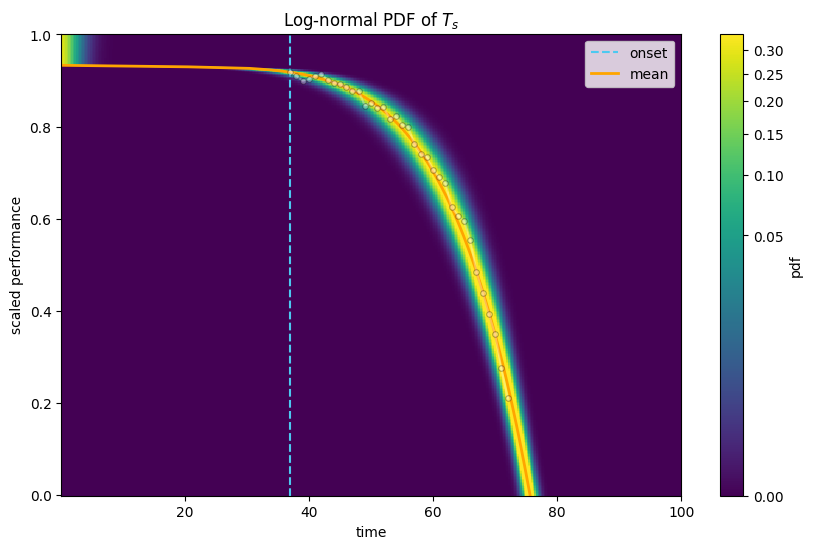

In [11]:
t = np.linspace(0.1, 100, 400)  # Start from 0.1 instead of 0.0 (LogNormal support is t > 0)
s = np.linspace(0.0, 1.0, 300)

best_model = NModel(onset=onset)
best_model.load_state_dict(
    torch.load(states_dir / "best_model.pt", map_location=device)
)
best_model.to(device)
best_model.eval()

ax = model.plot_distribution(
    t=t,
    s=s,
    func="pdf",
    title="Log-normal PDF of $T_s$",
)
ax.set_xlim([t.min(), t.max()])
ax.plot(t_np,s_np,'o-',
		color='white',alpha=0.3,markersize=4,markeredgecolor='black',markeredgewidth=0.8,
  		label='data')
display()

## Show parameters

In [12]:
for p in model.named_parameters():
    print(p)

('m0_raw', Parameter containing:
tensor(2.5882, device='cuda:0', requires_grad=True))
('m1_raw', Parameter containing:
tensor(75.6271, device='cuda:0', requires_grad=True))
('p_raw', Parameter containing:
tensor(-1.7219, device='cuda:0', requires_grad=True))
('v0_raw', Parameter containing:
tensor(-7.9421, device='cuda:0', requires_grad=True))
('v1_raw', Parameter containing:
tensor(1.0237, device='cuda:0', requires_grad=True))
